In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
import time
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import PIL 
from tqdm import tqdm
import matplotlib.pyplot as plt
# tsne and pca
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from IPython.display import clear_output
import untils

torch.Size([1, 1, 28, 28]) tensor([0])


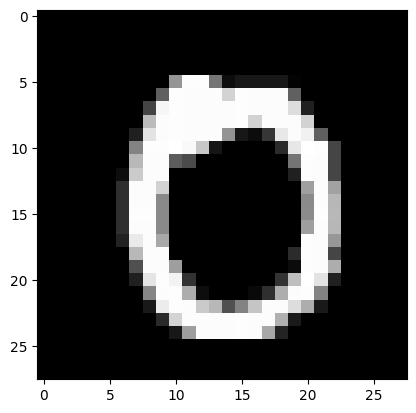

In [2]:
download = False
dataset_class = datasets.MNIST
mnist_transform = [transforms.ToTensor()]
# add normalization to the transform list such that all values are strictly greater than 0
# mnist_transform.append(transforms.Lambda(lambda x: x + 1e-5))

dataset_transform = transforms.Compose(mnist_transform)
mnist_train = dataset_class('data/MNIST', train=True, download=download, transform=dataset_transform)
mnist_test = dataset_class('data/MNIST', train=False, download=download, transform=dataset_transform)

# mnist_train.data.to('cuda')
# mnist_train.targets.to('cuda')
# # mnist_test.data.to('cuda')
# mnist_test.data.to('cuda')
# mnist_test.targets.to('cuda')
# mnist_test.labels
# create a dataloader with
#  batch size 1
mnist_train_loader = DataLoader(mnist_train, batch_size=1, shuffle=True)
mnist_test_loader = DataLoader(mnist_test, batch_size=1, shuffle=True)

# test the dataloader
for i, (data, target) in enumerate(mnist_train_loader):
    print(data.shape, target)
    # print(data)
    # display the first image
    plt.imshow(data[0, 0].numpy(), cmap='gray')
    plt.show()
    break

seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# randonly shuffle the training data
mnist_train_loader = DataLoader(mnist_train, batch_size=8, shuffle=True)

In [18]:
## Maximize predictive prower for each node
class CobwebNNTreeLayer(nn.Module):
    def __init__(self, n_hidden, n_clusters):
        super(CobwebNNTreeLayer, self).__init__()
        self.n_hidden = n_hidden
        self.n_clusters = n_clusters

        self.mean_l = nn.Parameter(torch.randn(n_clusters, n_hidden))
        self.cluster_weight = nn.Parameter(torch.randn(n_clusters, 1))

        self.prob_l = nn.Linear(n_hidden, n_clusters)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x, z, mean_root):
        # x: [batch_size, n_hidden]
        # z: [n_clusters, n_hidden]

        prob_l = self.sigmoid(self.prob_l(x)) # shape: batch_size, n_clusters
        prob_r = 1 - prob_l
        # print(f"prob_l: {prob_l.shape}, prob_r: {prob_r.shape}")
        # print(f"mean_l: {self.mean_l.shape}, mean_r: {mean_root.shape}")
        # print(f"z: {z.shape}")

        z_l = z + torch.log(prob_l)
        # print(f"z_l: {z_l.shape}")
        z_r = z + torch.log(prob_r)

        cluster_weight = self.sigmoid(self.cluster_weight)
        mean_l = torch.clamp(self.mean_l, min=mean_root/cluster_weight)

        # need to figure out a proper way to compute the mean_r so the gradeint won't be canceled out 
        mean_r = (mean_root - cluster_weight * mean_l) / (1 - cluster_weight) 
        # issue warning if mean_r contains negative values
        if (mean_r < 0).any():
            print(f"mean_r contains negative values: {mean_r}")
        if (mean_l < 0).any():
            print(f"mean_l contains negative values: {mean_l}")
        x_pred = torch.exp(z_l) @ mean_l + torch.exp(z_r) @ mean_r # shape: batch_size, n_hidden

        mean = torch.cat([mean_l, mean_r], dim=0)
        z = torch.cat([z_l, z_r], dim=0)

        return x_pred, prob_l, mean, z
    
class CobwebNN(nn.Module):
    def __init__(self, n_hidden, n_layers, imprint_dim):
        super(CobwebNN, self).__init__()
        self.n_hidden = n_hidden
        self.n_layers = n_layers
        self.imprint_dim = imprint_dim

        self.layers = nn.ModuleList([CobwebNNTreeLayer(n_hidden, 2**i) for i in range(0, n_layers)])

        self.mean_root = nn.Parameter(torch.rand(1, n_hidden))

    def imprint(self, x, y):
        # create a one-hot vector for the label
        y_onehot = F.one_hot(y, num_classes=self.imprint_dim).float() # shape: batch_size, imprint_dim
        # for each image in x, imprint the label at the first imprint_dim pixels
        x[:, :self.imprint_dim] += y_onehot
        return x
    
    def forward(self, x, y):
        x = x.view(-1, self.n_hidden)
        B = x.size(0)
        x_target = self.imprint(x, y)

        x_preds = []
        activations = []
        loss = 0

        # mean_root = torch.zeros(self.n_hidden) # need to add a root node that learns the mean of the input data
        mean_root = self.mean_root
        x_pred_0 = mean_root.expand_as(x)
        x_preds.append(x_pred_0)

        z = torch.zeros(B, 1, device=x.device)
        # print(f"z: {z.shape}")
        
        for i, layer in enumerate(self.layers):
            x_pred, prob_l, mean_root, z = layer(x, z, mean_root)
            activations.append(z)
            x_preds.append(x_pred)

        loss = 0
        for x_pred in x_preds:
            loss += F.mse_loss(x_pred, x_target)

        return untils.ModelOutput(loss=loss, reconstructions=x_preds, layer_outputs=activations)

        


In [19]:
n_layers = 1
model = CobwebNN(n_hidden=28*28, n_layers=n_layers, imprint_dim=10)
# model = CobwebSparse(n_layers=n_layers, branch_factor=2, n_input=64).to('cuda')

model.to('cuda')
optimizer = optim.Adam(model.parameters(), lr=3e-3)

untils.train_model(model, mnist_train, True, optimizer, epochs=1, batch_size=256, show_loss=True, 
                   device='cuda', verbose=False, early_break=False)
# display root_mean in matplotlib
root_mean = model.mean_root.cpu().detach().numpy().reshape(28, 28)
plt.imshow(root_mean)
plt.show()

Epoch 1/1:   1%|▏         | 3/235 [00:00<00:09, 24.27it/s, loss=0.478]

mean_r contains negative values: tensor([[-9.5012e-08,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00, -4.7506e-08,  9.5012e-08, -6.4331e-01,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00, -7.2647e-02,  0.0000e+00,
          0.0000e+00,  0.0000e+00, -4.0574e-01,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00, -1.6334e-01,  0.0000e+00,
          0.0000e+00,  0.0000e+00, -5.4394e-01,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00, -4.1350e-01,  0.0000e+00,
         -7.8791e-01,  4.7506e-08, -8.8481e-01,  0.0000e+00, -8.0601e-02,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  9.5012e-08,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         -8.0856e-02,  0.0000e+00,  0.0000e+00,  0.0000e+00, -1.6297e-01,
          0.0000e+00, -8.3920e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
     

Epoch 1/1:   4%|▍         | 9/235 [00:00<00:09, 22.72it/s, loss=0.427]

mean_r contains negative values: tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00, -6.6672e-01,  0.0000e+00,
         -5.9684e-09,  0.0000e+00,  0.0000e+00, -9.2507e-02,  2.3874e-08,
          0.0000e+00,  0.0000e+00, -4.3367e-01,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  9.5495e-08,  0.0000e+00, -1.5752e-01,  0.0000e+00,
          0.0000e+00,  0.0000e+00, -5.6051e-01, -2.3874e-08,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00, -4.3396e-01,  0.0000e+00,
         -7.9677e-01,  0.0000e+00, -9.0990e-01,  0.0000e+00, -9.9533e-02,
          9.5495e-08, -6.9339e-03,  0.0000e+00,  0.0000e+00, -9.5495e-08,
          0.0000e+00, -1.1937e-08, -5.9684e-09,  0.0000e+00,  0.0000e+00,
         -8.3456e-02,  0.0000e+00,  0.0000e+00,  0.0000e+00, -1.8921e-01,
          0.0000e+00, -8.6585e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
     

Epoch 1/1:   6%|▋         | 15/235 [00:00<00:09, 23.15it/s, loss=0.42] 

mean_r contains negative values: tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00, -9.5763e-08,  9.5763e-08,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00, -9.5763e-08, -6.5887e-01,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00, -1.0246e-01,  0.0000e+00,
          0.0000e+00,  0.0000e+00, -4.4947e-01,  0.0000e+00,  0.0000e+00,
          9.5763e-08, -1.0067e-02,  0.0000e+00, -1.2829e-01,  0.0000e+00,
          0.0000e+00,  0.0000e+00, -5.4262e-01,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00, -4.2684e-01,  0.0000e+00,
         -7.7394e-01,  0.0000e+00, -8.9922e-01,  0.0000e+00, -1.0702e-01,
          0.0000e+00, -4.0597e-02,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         -5.7154e-02,  0.0000e+00,  0.0000e+00,  0.0000e+00, -2.1162e-01,
          0.0000e+00, -8.5958e-01,  9.5763e-08, -9.5763e-08,  0.0000e+00,
     

Epoch 1/1:   8%|▊         | 18/235 [00:00<00:09, 21.94it/s, loss=0.411]

mean_r contains negative values: tensor([[ 9.5829e-08,  0.0000e+00,  0.0000e+00, -9.5829e-08, -9.5829e-08,
          4.7915e-08, -1.1979e-08,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  4.7915e-08,  0.0000e+00, -6.3164e-01,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00, -9.7290e-02,  0.0000e+00,
          0.0000e+00,  0.0000e+00, -4.4949e-01,  0.0000e+00,  0.0000e+00,
         -9.5829e-08, -4.0460e-02,  0.0000e+00, -9.5198e-02,  0.0000e+00,
          0.0000e+00, -9.5829e-08, -5.1184e-01, -2.3957e-08,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  4.7915e-08, -4.0066e-01,  0.0000e+00,
         -7.4162e-01,  0.0000e+00, -8.7046e-01,  0.0000e+00, -9.7907e-02,
         -9.5829e-08, -7.0688e-02,  0.0000e+00,  0.0000e+00, -9.5829e-08,
          0.0000e+00, -1.1979e-08, -2.9947e-09,  0.0000e+00,  0.0000e+00,
         -2.7625e-02,  0.0000e+00,  0.0000e+00,  0.0000e+00, -2.2195e-01,
          0.0000e+00, -8.3262e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
     

Epoch 1/1:  10%|█         | 24/235 [00:01<00:08, 23.96it/s, loss=0.415]

mean_r contains negative values: tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  9.5757e-08,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  9.5757e-08, -5.9654e-01,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00, -8.1749e-02,  0.0000e+00,
          0.0000e+00,  0.0000e+00, -4.3687e-01,  0.0000e+00,  0.0000e+00,
         -9.5757e-08, -6.8202e-02,  0.0000e+00, -6.3090e-02,  0.0000e+00,
          0.0000e+00,  0.0000e+00, -4.7585e-01,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00, -3.6715e-01,  0.0000e+00,
         -7.0437e-01,  0.0000e+00, -8.3382e-01,  0.0000e+00, -7.9118e-02,
         -9.5757e-08, -9.4722e-02,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00, -4.7878e-08,  0.0000e+00,
         -7.8331e-03,  0.0000e+00,  4.7878e-08,  0.0000e+00, -2.2418e-01,
          2.3939e-08, -7.9681e-01,  0.0000e+00, -9.5757e-08,  0.0000e+00,
     

Epoch 1/1:  13%|█▎        | 30/235 [00:01<00:08, 23.08it/s, loss=0.373]

mean_l contains negative values: tensor([[ 1.9591,  0.3551,  1.3923,  2.3593,  1.9681,  1.1795,  0.2988,  2.4447,
          0.7382,  0.7456,  1.4490,  1.1119,  2.2754,  1.4688,  1.4165,  0.0346,
          1.3745,  0.7037,  0.2754,  0.4322,  1.7717,  1.2530,  1.5572,  1.7123,
          0.6541,  2.3234,  2.0684,  1.6386,  0.2066,  0.0073,  0.5330,  2.4077,
          1.0754,  0.5000,  0.6181,  1.6781,  1.5252,  0.9494,  0.9667,  1.3023,
          1.3400,  0.8562,  1.9075,  1.3320,  0.2716,  2.4059,  1.2923,  1.5382,
          0.7203,  2.3433,  0.2882,  0.2001,  0.0304,  1.1353,  0.6334,  0.0983,
          0.1179,  1.1566,  1.2951,  1.0702,  0.6179,  1.9239,  1.9682,  2.1853,
          2.1764,  0.4079,  1.8860,  0.5737,  2.3173,  1.1456,  0.0117,  1.8410,
          1.0314,  0.8149,  0.4994,  0.9770,  0.5020,  0.9724,  2.4053,  1.7698,
          0.2901,  0.8989,  1.1298,  0.8279,  2.4094,  1.3153,  2.2668,  0.9448,
          1.3606,  2.4598,  2.0781,  1.7747,  1.6286,  1.1637,  0.6881,  1.3

Epoch 1/1:  14%|█▍        | 33/235 [00:01<00:08, 22.68it/s, loss=0.376]

mean_r contains negative values: tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          4.7688e-08,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00, -4.7688e-08,  0.0000e+00, -5.1864e-01,  0.0000e+00,
          7.4512e-10,  0.0000e+00,  0.0000e+00, -4.6104e-02,  0.0000e+00,
          0.0000e+00, -4.8648e-02, -3.9004e-01,  0.0000e+00,  0.0000e+00,
          0.0000e+00, -1.1019e-01,  0.0000e+00, -2.0416e-02,  0.0000e+00,
          2.3844e-08,  0.0000e+00, -3.9987e-01,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00, -2.9516e-01,  4.7688e-08,
         -6.2470e-01,  0.0000e+00, -7.5155e-01,  0.0000e+00, -4.1818e-02,
          0.0000e+00, -1.2173e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00, -4.7688e-08,  2.3844e-08,
         -1.1646e-02,  0.0000e+00,  0.0000e+00,  4.7688e-08, -2.1339e-01,
          2.3844e-08, -7.1534e-01,  0.0000e+00,  9.5375e-08,  0.0000e+00,
     

Epoch 1/1:  17%|█▋        | 39/235 [00:01<00:08, 22.34it/s, loss=0.373]

mean_r contains negative values: tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  9.5137e-08,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  9.5137e-08, -4.8069e-01,  0.0000e+00,
          0.0000e+00,  4.7568e-08,  0.0000e+00, -3.6958e-02,  0.0000e+00,
          0.0000e+00, -7.1750e-02, -3.6429e-01,  0.0000e+00, -2.3784e-08,
          9.5137e-08, -1.2543e-01,  0.0000e+00, -1.5365e-02,  0.0000e+00,
          0.0000e+00,  0.0000e+00, -3.6385e-01,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00, -2.6210e-01,  0.0000e+00,
         -5.8575e-01,  0.0000e+00, -7.1056e-01,  4.7568e-08, -3.4305e-02,
          0.0000e+00, -1.2862e-01,  0.0000e+00, -2.3784e-08,  9.5137e-08,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  2.3784e-08,
         -1.9323e-02,  0.0000e+00,  0.0000e+00,  0.0000e+00, -2.0510e-01,
          0.0000e+00, -6.7471e-01,  0.0000e+00,  0.0000e+00,  9.5137e-08,
     

Epoch 1/1:  19%|█▉        | 45/235 [00:01<00:08, 22.12it/s, loss=0.354]

mean_r contains negative values: tensor([[ 0.0000e+00,  0.0000e+00, -4.7443e-08,  9.4886e-08,  0.0000e+00,
         -4.7443e-08,  0.0000e+00,  0.0000e+00,  0.0000e+00,  2.3722e-08,
          0.0000e+00,  4.7443e-08,  9.4886e-08, -4.4469e-01,  0.0000e+00,
         -1.8532e-10,  0.0000e+00,  0.0000e+00, -3.4564e-02,  0.0000e+00,
          0.0000e+00, -8.7982e-02, -3.3967e-01,  0.0000e+00,  0.0000e+00,
          0.0000e+00, -1.3689e-01,  0.0000e+00, -1.8181e-02,  0.0000e+00,
          0.0000e+00,  0.0000e+00, -3.3025e-01,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00, -2.3260e-01,  4.7443e-08,
         -5.4827e-01,  0.0000e+00, -6.7083e-01,  4.7443e-08, -3.3809e-02,
          0.0000e+00, -1.3269e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  5.9304e-09,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         -2.0699e-02,  0.0000e+00,  0.0000e+00, -4.7443e-08, -1.9638e-01,
         -2.3722e-08, -6.3544e-01,  0.0000e+00,  9.4886e-08, -9.4886e-08,
     

Epoch 1/1:  20%|██        | 48/235 [00:02<00:08, 22.06it/s, loss=0.348]

mean_r contains negative values: tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  1.1829e-08, -9.4633e-08, -2.3658e-08,  0.0000e+00,
         -4.7316e-08,  0.0000e+00,  0.0000e+00, -4.1116e-01,  0.0000e+00,
          0.0000e+00,  4.7316e-08,  0.0000e+00, -3.6340e-02,  0.0000e+00,
          0.0000e+00, -9.7126e-02, -3.1738e-01,  0.0000e+00,  0.0000e+00,
          0.0000e+00, -1.4501e-01,  0.0000e+00, -2.4467e-02,  0.0000e+00,
          0.0000e+00, -9.4633e-08, -2.9954e-01,  0.0000e+00,  2.3658e-08,
          0.0000e+00,  0.0000e+00,  0.0000e+00, -2.0730e-01,  0.0000e+00,
         -5.1260e-01,  0.0000e+00, -6.3283e-01,  0.0000e+00, -3.6878e-02,
          0.0000e+00, -1.3481e-01,  0.0000e+00, -2.3658e-08, -9.4633e-08,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         -1.5757e-02,  0.0000e+00, -4.7316e-08, -4.7316e-08, -1.8792e-01,
         -2.3658e-08, -5.9802e-01,  0.0000e+00, -9.4633e-08,  0.0000e+00,
     

Epoch 1/1:  23%|██▎       | 54/235 [00:02<00:08, 21.85it/s, loss=0.34] 

mean_r contains negative values: tensor([[ 0.0000e+00,  0.0000e+00, -4.7193e-08,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  2.3597e-08,
         -4.7193e-08,  0.0000e+00,  0.0000e+00, -3.8097e-01,  0.0000e+00,
          0.0000e+00,  4.7193e-08,  0.0000e+00, -3.9562e-02,  1.1798e-08,
          0.0000e+00, -1.0247e-01, -2.9910e-01,  0.0000e+00,  0.0000e+00,
         -9.4386e-08, -1.5143e-01,  0.0000e+00, -3.0673e-02,  0.0000e+00,
          0.0000e+00,  0.0000e+00, -2.7247e-01,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00, -1.8714e-01,  0.0000e+00,
         -4.7936e-01,  0.0000e+00, -5.9731e-01,  0.0000e+00, -3.9811e-02,
         -9.4386e-08, -1.3633e-01,  0.0000e+00,  2.3597e-08, -9.4386e-08,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         -9.6144e-03,  0.0000e+00,  0.0000e+00, -4.7193e-08, -1.8092e-01,
          0.0000e+00, -5.6333e-01,  0.0000e+00,  9.4386e-08, -9.4386e-08,
     

Epoch 1/1:  24%|██▍       | 57/235 [00:02<00:08, 21.50it/s, loss=0.325]

mean_r contains negative values: tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00, -9.4152e-08,  0.0000e+00,
          0.0000e+00,  0.0000e+00, -9.4152e-08,  0.0000e+00, -2.3538e-08,
          0.0000e+00,  0.0000e+00,  0.0000e+00, -3.5445e-01,  0.0000e+00,
         -3.6778e-10,  4.7076e-08, -2.3538e-08, -4.1827e-02,  0.0000e+00,
          0.0000e+00, -1.0595e-01, -2.8547e-01,  0.0000e+00,  0.0000e+00,
         -9.4152e-08, -1.5701e-01,  0.0000e+00, -3.4456e-02,  0.0000e+00,
          0.0000e+00,  0.0000e+00, -2.4933e-01,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00, -1.7229e-01,  0.0000e+00,
         -4.4875e-01,  0.0000e+00, -5.6463e-01,  0.0000e+00, -4.1544e-02,
          9.4152e-08, -1.3782e-01,  0.0000e+00,  0.0000e+00, -9.4152e-08,
          0.0000e+00, -2.9422e-09,  3.6778e-10,  0.0000e+00,  0.0000e+00,
         -6.4828e-03,  0.0000e+00,  0.0000e+00,  0.0000e+00, -1.7584e-01,
          0.0000e+00, -5.3174e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
     

Epoch 1/1:  27%|██▋       | 63/235 [00:02<00:07, 21.73it/s, loss=0.326]

mean_l contains negative values: tensor([[ 1.7874e+00,  3.8926e-01,  1.2105e+00,  2.1963e+00,  1.7931e+00,
          9.9763e-01,  2.7466e-01,  2.2822e+00,  5.6980e-01,  5.7573e-01,
          1.2631e+00,  9.2149e-01,  2.1072e+00,  1.3700e+00,  1.2301e+00,
         -9.1841e-03,  1.1874e+00,  5.1387e-01,  1.9790e-01,  2.5371e-01,
          1.5920e+00,  1.2258e+00,  1.4544e+00,  1.5314e+00,  4.6530e-01,
          2.1563e+00,  2.0371e+00,  1.4562e+00,  1.5768e-01, -3.9076e-04,
          3.4832e-01,  2.2426e+00,  9.8048e-01,  3.1701e-01,  4.3035e-01,
          1.4965e+00,  1.3407e+00,  7.5809e-01,  8.7582e-01,  1.1142e+00,
          1.2395e+00,  6.6500e-01,  1.8049e+00,  1.1442e+00,  1.9621e-01,
          2.2408e+00,  1.2024e+00,  1.3540e+00,  5.3022e-01,  2.1766e+00,
          1.2674e-01,  5.8854e-02, -8.8189e-03,  9.6447e-01,  4.4515e-01,
          4.3405e-02,  9.7060e-03,  9.6663e-01,  1.1068e+00,  9.6041e-01,
          4.3005e-01,  1.8216e+00,  1.7928e+00,  2.0149e+00,  2.0059e+00,
     

Epoch 1/1:  29%|██▉       | 69/235 [00:03<00:07, 21.90it/s, loss=0.302]

mean_r contains negative values: tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00, -9.3781e-08,  0.0000e+00,  0.0000e+00,
         -4.6891e-08,  0.0000e+00,  9.3781e-08, -3.1842e-01,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00, -4.2274e-02,  0.0000e+00,
          0.0000e+00, -1.1371e-01, -2.7533e-01,  0.0000e+00,  0.0000e+00,
         -9.3781e-08, -1.6985e-01,  0.0000e+00, -3.4888e-02,  0.0000e+00,
          0.0000e+00, -9.3781e-08, -2.1915e-01,  0.0000e+00, -2.0867e-02,
          0.0000e+00,  0.0000e+00,  0.0000e+00, -1.5934e-01,  0.0000e+00,
         -4.0190e-01,  0.0000e+00, -5.1529e-01, -4.6891e-08, -4.1351e-02,
          0.0000e+00, -1.4319e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00, -4.0274e-02,  0.0000e+00,
         -8.3462e-03,  0.0000e+00,  0.0000e+00,  0.0000e+00, -1.7387e-01,
          0.0000e+00, -4.8504e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
     

Epoch 1/1:  31%|███       | 72/235 [00:03<00:07, 21.77it/s, loss=0.3]  

mean_r contains negative values: tensor([[ 0.0000e+00,  0.0000e+00,  4.6803e-08,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  2.3401e-08,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00, -3.0472e-01,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00, -4.0812e-02,  0.0000e+00,
          0.0000e+00, -1.1940e-01, -2.7650e-01,  0.0000e+00,  0.0000e+00,
          0.0000e+00, -1.7895e-01,  0.0000e+00, -3.2895e-02,  0.0000e+00,
         -6.8134e-03, -9.3605e-08, -2.0840e-01, -1.1701e-08, -4.5215e-02,
          0.0000e+00,  0.0000e+00,  0.0000e+00, -1.5859e-01,  0.0000e+00,
         -3.8040e-01,  2.3401e-08, -4.9311e-01, -4.6803e-08, -4.0088e-02,
          0.0000e+00, -1.4786e-01, -4.6803e-08,  0.0000e+00,  9.3605e-08,
          0.0000e+00,  0.0000e+00,  0.0000e+00, -6.9371e-02,  0.0000e+00,
         -8.7754e-03,  1.1426e-11,  0.0000e+00, -4.6803e-08, -1.7617e-01,
          0.0000e+00, -4.6476e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
     

Epoch 1/1:  33%|███▎      | 78/235 [00:03<00:06, 22.56it/s, loss=0.303]

mean_r contains negative values: tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00, -2.3363e-08,  2.3363e-08,
          4.6727e-08,  0.0000e+00,  0.0000e+00, -2.9555e-01, -4.6727e-08,
          0.0000e+00, -4.6727e-08,  0.0000e+00, -3.9381e-02,  0.0000e+00,
          0.0000e+00, -1.2671e-01, -2.8188e-01,  0.0000e+00,  0.0000e+00,
          0.0000e+00, -1.9012e-01,  4.6727e-08, -3.0922e-02,  0.0000e+00,
         -3.1079e-02,  0.0000e+00, -2.0176e-01,  0.0000e+00, -6.0092e-02,
          0.0000e+00,  0.0000e+00, -2.3363e-08, -1.6154e-01,  0.0000e+00,
         -3.6223e-01,  0.0000e+00, -4.7496e-01,  0.0000e+00, -3.9021e-02,
          9.3453e-08, -1.5402e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          2.9204e-09,  0.0000e+00,  0.0000e+00, -9.5600e-02,  0.0000e+00,
         -7.4647e-03,  0.0000e+00,  0.0000e+00,  4.6727e-08, -1.8070e-01,
          0.0000e+00, -4.4878e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
     

Epoch 1/1:  36%|███▌      | 84/235 [00:03<00:06, 23.25it/s, loss=0.294]

mean_r contains negative values: tensor([[ 0.0000e+00,  0.0000e+00, -4.6657e-08,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00, -2.8961e-01,  0.0000e+00,
          0.0000e+00, -4.6657e-08,  0.0000e+00, -3.7725e-02,  0.0000e+00,
          0.0000e+00, -1.3394e-01, -2.8906e-01,  0.0000e+00,  0.0000e+00,
          9.3314e-08, -2.0165e-01,  0.0000e+00, -2.9148e-02,  0.0000e+00,
         -4.6434e-02, -9.3314e-08, -1.9801e-01,  0.0000e+00, -6.3849e-02,
          0.0000e+00,  0.0000e+00,  0.0000e+00, -1.6633e-01,  0.0000e+00,
         -3.4658e-01,  0.0000e+00, -4.5980e-01,  0.0000e+00, -3.7460e-02,
          0.0000e+00, -1.6041e-01, -4.6657e-08,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00, -1.1480e-01,  0.0000e+00,
         -5.2979e-03,  1.8225e-10,  0.0000e+00,  0.0000e+00, -1.8579e-01,
          0.0000e+00, -4.3596e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
     

Epoch 1/1:  37%|███▋      | 87/235 [00:03<00:06, 23.54it/s, loss=0.3]  

mean_r contains negative values: tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00, -9.3187e-08,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00, -2.8677e-01,  4.6593e-08,
          0.0000e+00,  0.0000e+00,  0.0000e+00, -3.6567e-02,  0.0000e+00,
          0.0000e+00, -1.4164e-01, -2.9779e-01,  0.0000e+00,  1.1648e-08,
          9.3187e-08, -2.1408e-01,  0.0000e+00, -2.8132e-02,  0.0000e+00,
         -5.0370e-02,  0.0000e+00, -1.9691e-01,  0.0000e+00, -6.3056e-02,
          4.6593e-08,  0.0000e+00,  2.3297e-08, -1.7247e-01,  0.0000e+00,
         -3.3357e-01,  0.0000e+00, -4.4767e-01,  0.0000e+00, -3.6297e-02,
          0.0000e+00, -1.6738e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00, -1.2825e-01,  0.0000e+00,
         -3.8881e-03,  1.8201e-10,  0.0000e+00,  0.0000e+00, -1.9146e-01,
          0.0000e+00, -4.2638e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
     

Epoch 1/1:  40%|███▉      | 93/235 [00:04<00:05, 24.18it/s, loss=0.276]

mean_l contains negative values: tensor([[ 1.6144e+00,  4.0624e-01,  1.0428e+00,  2.0243e+00,  1.6197e+00,
          8.3858e-01,  3.1741e-01,  2.1088e+00,  4.5139e-01,  4.6581e-01,
          1.0843e+00,  7.4780e-01,  1.9294e+00,  1.3208e+00,  1.0516e+00,
          1.4530e-03,  1.0093e+00,  3.5903e-01,  1.4615e-01,  1.3289e-01,
          1.4122e+00,  1.1479e+00,  1.3981e+00,  1.3515e+00,  3.1468e-01,
          1.9789e+00,  1.9979e+00,  1.2765e+00,  1.1724e-01, -1.6449e-04,
          3.0501e-01,  2.0658e+00,  9.3688e-01,  1.8465e-01,  4.0417e-01,
          1.3169e+00,  1.1616e+00,  5.8959e-01,  8.3472e-01,  9.3702e-01,
          1.1856e+00,  5.0072e-01,  1.7484e+00,  9.6656e-01,  1.4496e-01,
          2.0639e+00,  1.1292e+00,  1.1746e+00,  3.7409e-01,  1.9993e+00,
          4.2136e-02,  7.4119e-03,  1.6178e-03,  1.0203e+00,  2.9649e-01,
          1.6402e-02, -3.9830e-03,  7.9193e-01,  9.2967e-01,  8.9423e-01,
          2.8294e-01,  1.7663e+00,  1.6134e+00,  1.8368e+00,  1.8278e+00,
     

Epoch 1/1:  41%|████      | 96/235 [00:04<00:06, 22.79it/s, loss=0.276]

mean_r contains negative values: tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00, -9.3001e-08,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00, -2.9154e-01,  0.0000e+00,
          0.0000e+00,  0.0000e+00, -1.1625e-08, -3.7543e-02,  0.0000e+00,
          0.0000e+00, -1.6224e-01, -3.2190e-01,  4.6501e-08,  0.0000e+00,
          0.0000e+00, -2.4576e-01, -4.6501e-08, -2.9188e-02,  0.0000e+00,
         -4.8025e-02,  0.0000e+00, -2.0309e-01,  0.0000e+00, -6.2122e-02,
          0.0000e+00,  0.0000e+00, -2.3250e-08, -1.8915e-01,  0.0000e+00,
         -3.1678e-01,  0.0000e+00, -4.3468e-01,  0.0000e+00, -3.7391e-02,
          0.0000e+00, -1.8548e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00, -1.4956e-01,  1.1625e-08,
         -4.0786e-03,  0.0000e+00,  0.0000e+00,  0.0000e+00, -2.0682e-01,
          1.1625e-08, -4.1903e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
     

Epoch 1/1:  43%|████▎     | 102/235 [00:04<00:05, 22.22it/s, loss=0.257]

mean_r contains negative values: tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00, -2.9839e-01,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  1.1618e-08, -3.8541e-02,  0.0000e+00,
          0.0000e+00, -1.7480e-01, -3.3646e-01,  4.6473e-08,  0.0000e+00,
          0.0000e+00, -2.6486e-01,  0.0000e+00, -3.0260e-02,  0.0000e+00,
         -4.6890e-02,  0.0000e+00, -2.0957e-01, -5.8092e-09, -6.3676e-02,
         -4.6473e-08,  0.0000e+00,  2.3237e-08, -1.9898e-01,  0.0000e+00,
         -3.1272e-01,  0.0000e+00, -4.3354e-01,  0.0000e+00, -3.8067e-02,
          0.0000e+00, -1.9639e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  4.5384e-11, -1.5975e-01,  0.0000e+00,
         -3.9860e-03,  0.0000e+00,  0.0000e+00,  0.0000e+00, -2.1606e-01,
          0.0000e+00, -4.2085e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
     

Epoch 1/1:  46%|████▌     | 108/235 [00:04<00:05, 22.01it/s, loss=0.25] 

mean_r contains negative values: tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00, -1.1615e-08,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00, -2.3230e-08,  0.0000e+00, -3.0772e-01,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00, -3.9264e-02,  0.0000e+00,
          0.0000e+00, -1.8857e-01, -3.5229e-01, -4.6460e-08,  0.0000e+00,
          0.0000e+00, -2.8593e-01,  0.0000e+00, -3.1137e-02,  0.0000e+00,
         -4.7048e-02,  0.0000e+00, -2.1783e-01,  0.0000e+00, -6.6523e-02,
          4.6460e-08,  0.0000e+00,  0.0000e+00, -2.0937e-01,  0.0000e+00,
         -3.1132e-01,  0.0000e+00, -4.3562e-01,  0.0000e+00, -3.8502e-02,
          0.0000e+00, -2.0840e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         -7.2594e-10,  0.0000e+00,  0.0000e+00, -1.7053e-01,  0.0000e+00,
         -3.4007e-03,  0.0000e+00,  0.0000e+00,  0.0000e+00, -2.2607e-01,
          0.0000e+00, -4.2601e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
     

Epoch 1/1:  49%|████▊     | 114/235 [00:05<00:05, 21.88it/s, loss=0.252]

mean_r contains negative values: tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  2.3228e-08,  0.0000e+00, -3.1831e-01,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00, -3.8939e-02,  2.9035e-09,
          0.0000e+00, -2.0222e-01, -3.6774e-01,  0.0000e+00,  0.0000e+00,
          0.0000e+00, -3.0766e-01, -4.6456e-08, -3.1225e-02,  0.0000e+00,
         -4.7557e-02,  0.0000e+00, -2.2685e-01,  0.0000e+00, -6.9333e-02,
          0.0000e+00,  4.6456e-08,  0.0000e+00, -2.1929e-01,  0.0000e+00,
         -3.1175e-01,  0.0000e+00, -4.3988e-01,  0.0000e+00, -3.7125e-02,
          0.0000e+00, -2.2054e-01,  0.0000e+00, -2.0710e-02,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00, -1.8076e-01,  0.0000e+00,
         -2.6414e-03,  0.0000e+00,  0.0000e+00,  0.0000e+00, -2.3555e-01,
          0.0000e+00, -4.3329e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
     

Epoch 1/1:  50%|████▉     | 117/235 [00:05<00:05, 21.73it/s, loss=0.247]

mean_r contains negative values: tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00, -3.2710e-01,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00, -3.6012e-02,  0.0000e+00,
          0.0000e+00, -2.1103e-01, -3.7828e-01,  0.0000e+00,  0.0000e+00,
          0.0000e+00, -3.2501e-01,  0.0000e+00, -2.9371e-02,  0.0000e+00,
         -4.4970e-02,  0.0000e+00, -2.3410e-01,  0.0000e+00, -6.8395e-02,
          0.0000e+00,  0.0000e+00,  0.0000e+00, -2.2573e-01,  0.0000e+00,
         -3.1194e-01,  0.0000e+00, -4.4350e-01,  0.0000e+00, -3.3407e-02,
          0.0000e+00, -2.2945e-01,  0.0000e+00, -4.7233e-02,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00, -1.8527e-01,  0.0000e+00,
         -1.9098e-03,  0.0000e+00,  2.3222e-08,  0.0000e+00, -2.4087e-01,
          0.0000e+00, -4.3953e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
     

Epoch 1/1:  51%|█████     | 120/235 [00:05<00:05, 21.78it/s, loss=0.238]

mean_r contains negative values: tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         -2.3214e-08,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  2.3214e-08,  0.0000e+00, -3.3487e-01,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00, -3.2665e-02,  0.0000e+00,
          0.0000e+00, -2.1705e-01, -3.8569e-01,  0.0000e+00, -1.5501e-03,
          0.0000e+00, -3.3981e-01,  4.6429e-08, -2.6912e-02,  0.0000e+00,
         -4.1325e-02,  0.0000e+00, -2.4025e-01,  0.0000e+00, -6.5721e-02,
          0.0000e+00,  0.0000e+00,  0.0000e+00, -2.2994e-01,  0.0000e+00,
         -3.1236e-01,  0.0000e+00, -4.4719e-01,  0.0000e+00, -2.9727e-02,
          0.0000e+00, -2.3640e-01,  0.0000e+00, -6.7196e-02,  0.0000e+00,
          0.0000e+00,  0.0000e+00, -1.1335e-11, -1.8710e-01,  0.0000e+00,
         -1.6056e-03,  0.0000e+00,  0.0000e+00,  0.0000e+00, -2.4355e-01,
          0.0000e+00, -4.4550e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
     

Epoch 1/1:  54%|█████▎    | 126/235 [00:05<00:06, 16.63it/s, loss=0.243]

mean_l contains negative values: tensor([[ 1.4091e+00,  3.8115e-01,  8.6564e-01,  1.8052e+00,  1.4125e+00,
          6.7917e-01,  3.3887e-01,  1.8888e+00,  3.6083e-01,  3.7919e-01,
          8.8007e-01,  5.6164e-01,  1.7049e+00,  1.2937e+00,  8.4870e-01,
         -2.7757e-04,  8.0824e-01,  2.1654e-01,  1.0974e-01,  4.9900e-02,
          1.1974e+00,  1.0954e+00,  1.3550e+00,  1.1384e+00,  1.9788e-01,
          1.7538e+00,  2.0009e+00,  1.0655e+00,  8.8803e-02, -2.4211e-05,
          1.9802e-01,  1.8397e+00,  9.1295e-01,  8.3295e-02,  3.0363e-01,
          1.1046e+00,  9.5434e-01,  4.1694e-01,  8.0347e-01,  7.3960e-01,
          1.1577e+00,  3.3796e-01,  1.7182e+00,  7.6785e-01,  1.0867e-01,
          1.8378e+00,  1.0770e+00,  9.6697e-01,  3.5751e-01,  1.7739e+00,
          5.5028e-03, -1.6900e-03, -3.2258e-04,  9.4713e-01,  1.6610e-01,
          5.9941e-03,  1.5913e-04,  6.0274e-01,  7.3247e-01,  8.4135e-01,
          1.5549e-01,  1.7367e+00,  1.3941e+00,  1.6138e+00,  1.6050e+00,
     

Epoch 1/1:  55%|█████▍    | 129/235 [00:06<00:05, 17.82it/s, loss=0.231]

mean_r contains negative values: tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00, -2.3210e-08,  0.0000e+00, -3.4645e-01,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00, -3.0890e-02,  0.0000e+00,
          0.0000e+00, -2.2560e-01, -3.9563e-01,  0.0000e+00, -3.4680e-02,
          0.0000e+00, -3.6106e-01,  0.0000e+00, -2.5001e-02,  0.0000e+00,
         -3.8300e-02,  0.0000e+00, -2.4902e-01,  0.0000e+00, -6.3123e-02,
          0.0000e+00,  0.0000e+00,  0.0000e+00, -2.3548e-01,  0.0000e+00,
         -3.1490e-01,  0.0000e+00, -4.5455e-01,  0.0000e+00, -2.9760e-02,
          0.0000e+00, -2.4618e-01,  0.0000e+00, -7.9986e-02,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00, -1.9083e-01, -5.8024e-09,
         -1.7101e-03,  0.0000e+00,  0.0000e+00,  0.0000e+00, -2.4704e-01,
          0.0000e+00, -4.5580e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
     

Epoch 1/1:  57%|█████▋    | 135/235 [00:06<00:04, 20.35it/s, loss=0.235]

mean_r contains negative values: tensor([[ 4.6403e-08,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  1.1601e-08,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00, -2.3201e-08,  0.0000e+00, -3.5262e-01,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00, -2.9862e-02,  1.4501e-09,
         -4.6403e-08, -2.2841e-01, -3.9878e-01,  0.0000e+00, -5.0472e-02,
          0.0000e+00, -3.7236e-01,  0.0000e+00, -2.3804e-02,  0.0000e+00,
         -3.5394e-02,  0.0000e+00, -2.5333e-01,  0.0000e+00, -5.9870e-02,
          4.6403e-08,  0.0000e+00,  0.0000e+00, -2.3673e-01,  0.0000e+00,
         -3.1619e-01,  0.0000e+00, -4.5873e-01,  0.0000e+00, -3.0081e-02,
          0.0000e+00, -2.5057e-01,  0.0000e+00, -7.7124e-02,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00, -1.9076e-01, -9.0077e-03,
         -1.5093e-03,  0.0000e+00,  0.0000e+00,  0.0000e+00, -2.4660e-01,
          0.0000e+00, -4.6174e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
     

Epoch 1/1:  60%|██████    | 141/235 [00:06<00:04, 22.17it/s, loss=0.217]

mean_r contains negative values: tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         -2.3192e-08,  1.1596e-08,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00, -3.5801e-01,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  5.7981e-09, -2.9158e-02,  0.0000e+00,
          0.0000e+00, -2.3016e-01, -4.0062e-01,  4.6385e-08, -5.3673e-02,
          0.0000e+00, -3.8219e-01,  0.0000e+00, -2.3028e-02,  0.0000e+00,
         -3.2767e-02,  0.0000e+00, -2.5687e-01,  0.0000e+00, -5.6641e-02,
          0.0000e+00,  0.0000e+00,  0.0000e+00, -2.3707e-01,  0.0000e+00,
         -3.1763e-01,  1.1596e-08, -4.6288e-01,  0.0000e+00, -2.9327e-02,
          0.0000e+00, -2.5394e-01,  0.0000e+00, -7.0818e-02,  0.0000e+00,
          2.2649e-11, -4.5297e-11,  0.0000e+00, -1.9014e-01, -3.1585e-02,
         -1.1694e-03,  0.0000e+00, -1.9036e-02, -2.3192e-08, -2.4539e-01,
          0.0000e+00, -4.6742e-01, -4.6385e-08,  0.0000e+00,  0.0000e+00,
     

Epoch 1/1:  61%|██████▏   | 144/235 [00:06<00:03, 22.77it/s, loss=0.238]

mean_r contains negative values: tensor([[ 4.6367e-08,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00, -3.6316e-01,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00, -2.8728e-02,  0.0000e+00,
          4.6367e-08, -2.3174e-01, -4.0230e-01,  0.0000e+00, -4.9411e-02,
          0.0000e+00, -3.9147e-01,  0.0000e+00, -2.2659e-02, -7.0750e-13,
         -3.0792e-02,  0.0000e+00, -2.6011e-01,  0.0000e+00, -5.4004e-02,
          0.0000e+00,  0.0000e+00,  0.0000e+00, -2.3740e-01,  0.0000e+00,
         -3.1949e-01,  0.0000e+00, -4.6742e-01, -2.3184e-08, -2.8279e-02,
          0.0000e+00, -2.5693e-01,  0.0000e+00, -6.4250e-02,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00, -1.8987e-01, -4.4867e-02,
         -9.2916e-04,  0.0000e+00, -5.1877e-02, -2.3184e-08, -2.4435e-01,
          0.0000e+00, -4.7326e-01,  4.6367e-08,  0.0000e+00,  0.0000e+00,
     

Epoch 1/1:  64%|██████▍   | 150/235 [00:06<00:03, 22.72it/s, loss=0.219]

mean_r contains negative values: tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00, -3.6847e-01,  0.0000e+00,
          0.0000e+00,  0.0000e+00, -5.7940e-09, -2.8431e-02, -5.2578e-03,
          0.0000e+00, -2.3357e-01, -4.0470e-01,  0.0000e+00, -4.2843e-02,
          0.0000e+00, -4.0065e-01,  0.0000e+00, -2.2537e-02, -8.8409e-14,
         -2.9450e-02,  0.0000e+00, -2.6344e-01,  0.0000e+00, -5.2099e-02,
          0.0000e+00,  0.0000e+00,  0.0000e+00, -2.3831e-01,  0.0000e+00,
         -3.2195e-01,  0.0000e+00, -4.7266e-01,  0.0000e+00, -2.7834e-02,
          0.0000e+00, -2.5992e-01,  0.0000e+00, -5.8949e-02,  0.0000e+00,
          2.2633e-11,  0.0000e+00,  0.0000e+00, -1.9024e-01, -4.3998e-02,
         -8.5928e-04,  0.0000e+00, -8.4095e-02,  2.3176e-08, -2.4415e-01,
          0.0000e+00, -4.7961e-01, -4.6352e-08,  0.0000e+00,  0.0000e+00,
     

Epoch 1/1:  65%|██████▌   | 153/235 [00:07<00:03, 22.31it/s, loss=0.224]

mean_r contains negative values: tensor([[-4.6345e-08,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00, -3.7485e-01, -2.3172e-08,
          0.0000e+00,  2.3172e-08,  0.0000e+00, -2.8403e-02, -8.0703e-03,
          0.0000e+00, -2.3679e-01, -4.0923e-01,  0.0000e+00, -3.7626e-02,
          0.0000e+00, -4.1123e-01,  0.0000e+00, -2.2658e-02,  0.0000e+00,
         -2.8943e-02,  0.0000e+00, -2.6761e-01,  0.0000e+00, -5.1329e-02,
          0.0000e+00,  0.0000e+00,  1.1586e-08, -2.4045e-01,  0.0000e+00,
         -3.2549e-01,  0.0000e+00, -4.7934e-01,  0.0000e+00, -2.7685e-02,
          0.0000e+00, -2.6387e-01,  0.0000e+00, -5.6060e-02,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  2.8286e-12, -1.9231e-01, -3.7877e-02,
         -8.6014e-04,  0.0000e+00, -1.1320e-01,  0.0000e+00, -2.4582e-01,
          0.0000e+00, -4.8734e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
     

Epoch 1/1:  68%|██████▊   | 159/235 [00:07<00:03, 21.84it/s, loss=0.207]

mean_r contains negative values: tensor([[ 4.6347e-08,  0.0000e+00,  0.0000e+00,  0.0000e+00, -4.6347e-08,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00, -3.8247e-01,  0.0000e+00,
          0.0000e+00, -2.3173e-08,  0.0000e+00, -2.8498e-02, -4.0289e-04,
          0.0000e+00, -2.4158e-01, -4.1610e-01,  0.0000e+00, -3.5081e-02,
          0.0000e+00, -4.2362e-01,  0.0000e+00, -2.2849e-02,  0.0000e+00,
         -2.9075e-02,  0.0000e+00, -2.7279e-01,  0.0000e+00, -5.1563e-02,
          0.0000e+00,  0.0000e+00,  1.1587e-08, -2.4427e-01,  0.0000e+00,
         -3.3028e-01,  0.0000e+00, -4.8759e-01,  0.0000e+00, -2.6002e-02,
          0.0000e+00, -2.6895e-01,  0.0000e+00, -5.5528e-02,  0.0000e+00,
          0.0000e+00,  2.8288e-12,  0.0000e+00, -1.9616e-01, -3.1953e-02,
         -8.1544e-04,  0.0000e+00, -1.3749e-01, -2.3173e-08, -2.4939e-01,
          0.0000e+00, -4.9661e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
     

Epoch 1/1:  70%|███████   | 165/235 [00:07<00:03, 21.39it/s, loss=0.215]

mean_r contains negative values: tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  1.1589e-08,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00, -3.9076e-01, -2.3178e-08,
          1.4147e-12,  0.0000e+00,  0.0000e+00, -2.8237e-02, -3.7164e-03,
          0.0000e+00, -2.4718e-01, -4.2418e-01,  0.0000e+00, -3.4366e-02,
          0.0000e+00, -4.3698e-01,  0.0000e+00, -2.2757e-02,  1.7683e-13,
         -2.9188e-02,  0.0000e+00, -2.7848e-01, -7.2431e-10, -5.2076e-02,
          0.0000e+00,  0.0000e+00,  0.0000e+00, -2.4896e-01,  0.0000e+00,
         -3.3588e-01,  0.0000e+00, -4.9683e-01,  0.0000e+00, -2.4892e-02,
          0.0000e+00, -2.7459e-01,  0.0000e+00, -5.6192e-02,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00, -2.0088e-01, -2.7843e-02,
         -6.9342e-04,  0.0000e+00, -1.5616e-01,  0.0000e+00, -2.5390e-01,
          0.0000e+00, -5.0680e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
     

Epoch 1/1:  71%|███████▏  | 168/235 [00:07<00:03, 21.44it/s, loss=0.204]

mean_l contains negative values: tensor([[ 1.1473e+00,  3.5862e-01,  6.6197e-01,  1.5127e+00,  1.1436e+00,
          5.0663e-01,  3.2521e-01,  1.5912e+00,  3.1350e-01,  3.3029e-01,
          6.2558e-01,  3.4745e-01,  1.4009e+00,  1.2577e+00,  5.9732e-01,
          1.7388e-05,  5.6110e-01,  8.7963e-02,  7.6364e-02,  1.6594e-02,
          9.1799e-01,  9.6771e-01,  1.2929e+00,  8.6285e-01,  1.4335e-01,
          1.4480e+00,  1.9351e+00,  7.9518e-01,  6.1853e-02,  4.0030e-06,
          1.0520e-01,  1.5310e+00,  8.7890e-01,  1.7971e-02,  1.9004e-01,
          8.3139e-01,  6.9304e-01,  2.3058e-01,  7.5673e-01,  5.0066e-01,
          1.1313e+00,  1.7158e-01,  1.6872e+00,  5.2549e-01,  7.5996e-02,
          1.5294e+00,  9.8058e-01,  7.0455e-01,  2.2594e-01,  1.4674e+00,
         -6.5025e-04,  7.2509e-05,  4.1324e-06,  8.0416e-01,  1.1497e-01,
          1.6913e-03, -4.0684e-05,  6.8033e-01,  4.9405e-01,  7.6902e-01,
          5.2335e-02,  1.7040e+00,  1.1036e+00,  1.3133e+00,  1.3049e+00,
     

Epoch 1/1:  74%|███████▍  | 174/235 [00:08<00:02, 21.52it/s, loss=0.196]

mean_r contains negative values: tensor([[-4.6367e-08,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         -7.4712e-03,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          2.3184e-08, -1.1592e-08,  0.0000e+00, -4.0366e-01, -1.9062e-03,
          0.0000e+00,  0.0000e+00,  0.0000e+00, -2.5811e-02, -2.7763e-04,
          0.0000e+00, -2.5517e-01, -4.3555e-01,  0.0000e+00, -3.3099e-02,
          0.0000e+00, -4.5866e-01,  0.0000e+00, -2.1073e-02,  0.0000e+00,
         -2.7403e-02,  0.0000e+00, -2.8698e-01,  0.0000e+00, -5.1136e-02,
          0.0000e+00,  0.0000e+00,  0.0000e+00, -2.5512e-01,  0.0000e+00,
         -3.4537e-01,  0.0000e+00, -5.1239e-01,  0.0000e+00, -2.5424e-02,
          0.0000e+00, -2.8289e-01, -2.3184e-08, -5.6156e-02,  0.0000e+00,
         -2.2640e-11,  0.0000e+00,  0.0000e+00, -2.0721e-01, -2.3737e-02,
         -4.6612e-04,  0.0000e+00, -1.7331e-01,  0.0000e+00, -2.5944e-01,
          0.0000e+00, -5.2370e-01,  4.6367e-08,  0.0000e+00,  0.0000e+00,
     

Epoch 1/1:  77%|███████▋  | 180/235 [00:08<00:02, 23.13it/s, loss=0.191]

mean_r contains negative values: tensor([[ 4.6369e-08,  0.0000e+00,  0.0000e+00,  0.0000e+00, -4.6369e-08,
         -1.6828e-02,  0.0000e+00,  0.0000e+00, -1.1592e-08,  0.0000e+00,
          2.3184e-08,  0.0000e+00, -4.6369e-08, -4.0975e-01, -3.2552e-02,
          0.0000e+00, -2.3184e-08,  0.0000e+00, -2.4509e-02,  0.0000e+00,
          0.0000e+00, -2.5859e-01, -4.4021e-01,  0.0000e+00, -3.1969e-02,
          0.0000e+00, -4.6952e-01,  0.0000e+00, -1.9984e-02,  0.0000e+00,
         -2.5653e-02,  0.0000e+00, -2.9080e-01,  0.0000e+00, -4.9741e-02,
          0.0000e+00,  0.0000e+00,  0.0000e+00, -2.5749e-01,  0.0000e+00,
         -3.5028e-01, -1.3298e-02, -5.2039e-01,  0.0000e+00, -2.3835e-02,
          0.0000e+00, -2.8647e-01,  0.0000e+00, -5.4980e-02,  0.0000e+00,
          0.0000e+00,  0.0000e+00, -7.0753e-13, -2.0964e-01, -2.2850e-02,
         -4.3617e-04,  0.0000e+00, -1.7646e-01,  0.0000e+00, -2.6116e-01,
          0.0000e+00, -5.3224e-01,  0.0000e+00,  4.6369e-08,  0.0000e+00,
     

Epoch 1/1:  78%|███████▊  | 183/235 [00:08<00:02, 22.71it/s, loss=0.187]

mean_r contains negative values: tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         -2.0843e-02,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00, -1.1595e-08,  0.0000e+00, -4.1691e-01, -6.8759e-02,
          0.0000e+00,  0.0000e+00,  0.0000e+00, -2.4430e-02,  0.0000e+00,
          0.0000e+00, -2.6316e-01, -4.4659e-01,  0.0000e+00, -3.1597e-02,
         -4.6380e-08, -4.8198e-01,  0.0000e+00, -1.9652e-02,  4.4231e-14,
         -2.4361e-02,  0.0000e+00, -2.9548e-01,  0.0000e+00, -4.8818e-02,
          0.0000e+00,  0.0000e+00,  0.0000e+00, -2.6105e-01,  0.0000e+00,
         -3.5614e-01, -3.9825e-02, -5.2962e-01,  0.0000e+00, -2.2173e-02,
          0.0000e+00, -2.9099e-01,  0.0000e+00, -5.4541e-02,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00, -2.1318e-01, -2.3357e-02,
         -4.5453e-04,  1.4154e-12, -1.7905e-01,  0.0000e+00, -2.6412e-01,
         -1.4494e-09, -5.4200e-01,  0.0000e+00, -4.6380e-08,  0.0000e+00,
     

Epoch 1/1:  80%|███████▉  | 187/235 [00:08<00:02, 21.80it/s, loss=0.206]


mean_r contains negative values: tensor([[-4.6394e-08,  1.1598e-08, -2.3197e-08, -4.6394e-08,  0.0000e+00,
         -2.8241e-02,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.1598e-08,
          0.0000e+00,  0.0000e+00,  0.0000e+00, -4.2416e-01, -1.0410e-01,
          0.0000e+00,  0.0000e+00,  0.0000e+00, -2.4644e-02,  0.0000e+00,
          0.0000e+00, -2.6771e-01, -4.5314e-01,  0.0000e+00, -3.1022e-02,
          0.0000e+00, -4.9455e-01,  0.0000e+00, -1.9607e-02,  0.0000e+00,
         -2.3152e-02,  0.0000e+00, -3.0024e-01,  0.0000e+00, -4.7829e-02,
          0.0000e+00,  0.0000e+00, -5.7992e-09, -2.6468e-01,  0.0000e+00,
         -3.6229e-01, -6.0880e-02, -5.3919e-01,  0.0000e+00, -2.2176e-02,
          0.0000e+00, -2.9558e-01,  0.0000e+00, -5.3630e-02,  0.0000e+00,
          0.0000e+00, -2.8316e-12,  0.0000e+00, -2.1663e-01, -2.3602e-02,
         -4.2948e-04, -7.0791e-13, -1.8041e-01,  0.0000e+00, -2.6714e-01,
          0.0000e+00, -5.5200e-01,  0.0000e+00,  4.6394e-08,  0.0000e+00,
     

KeyboardInterrupt: 

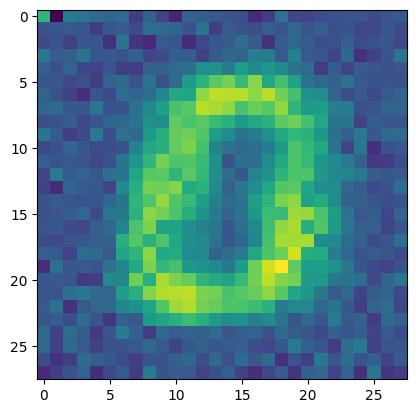

In [41]:
cluster_l = model.layers[0].mean_l.cpu().detach().numpy().reshape(28, 28)
plt.imshow(cluster_l)

In [42]:
model.layers[0].cluster_weight

Parameter containing:
tensor([[0.4323]], device='cuda:0', requires_grad=True)

In [43]:
cluster_l

array([[ 7.04520166e-01, -4.73193556e-01,  2.80934572e-01,
         2.16249242e-01,  1.78375915e-01,  1.12733521e-01,
         1.62960649e-01, -1.50445521e-01,  8.97001922e-02,
        -1.24006443e-01, -2.85803705e-01,  9.18875784e-02,
         7.68251419e-02,  1.39513118e-02, -7.71984574e-04,
        -3.21752578e-02, -2.52192110e-01, -1.51392102e-01,
         2.04052061e-01, -9.19381231e-02, -1.11381426e-01,
        -5.00113405e-02, -1.54909678e-02,  8.84800032e-03,
        -2.61028094e-04, -5.30203730e-02,  2.82353547e-04,
         4.09500115e-02],
       [-1.04875881e-02,  1.13360733e-02,  2.93507744e-02,
         7.95032643e-03, -1.52151436e-01,  2.69280449e-02,
         5.56330793e-02, -6.97993711e-02,  1.77834332e-01,
         1.50751427e-01,  1.17053650e-01, -4.53660684e-03,
         2.20078811e-01, -1.41357824e-01,  4.46148217e-02,
        -1.47014922e-02, -3.78997587e-02,  7.53017068e-02,
         7.36211007e-03,  1.19504340e-01,  1.53586490e-03,
         7.68145844e-02, -3.49

In [234]:
# little experiment:
# random input x with shape [batch_size, n_hidden]
batech_size = 100
n_hidden = 784
x = torch.rand(batech_size, n_hidden)
x_mean = x.mean(dim=0)

# a random weight matrix with shape [n_clusters, n_hidden]
n_clusters = 1
mean_l = nn.Parameter(torch.rand(n_clusters, n_hidden))

# forward pass
out = x @ mean_l.t()
# out = F.softmax(out, dim=1)
x_pred = out @ mean_l
# distance between x and x_pred
dist = F.mse_loss(x, x_pred, reduction='mean')
print(dist)

tensor(12679.3535, grad_fn=<MseLossBackward0>)


In [5]:
data = torch.rand(5, 10)
data_mean = data.mean(dim=0)
print(f"range of data_mean: {data_mean.min()}, {data_mean.max()}")

left_split_probs = torch.rand(5, 1)
# left_split_probs = torch.tensor([0.5] * 5).view(-1, 1)
# random 1'seed
# left_split_probs = torch.tensor([0.0, 1.0, 0.0, 0.0, 1.0]).view(-1, 1)
left_split_probs = torch.tensor([1e-3, 1.789e-4, 0.0072, 0.01, 0.00082]).view(-1, 1)

right_split_probs = 1 - left_split_probs
# left_split_probs = F.softmax(left_split_probs, dim=0)
# right_split_probs = F.softmax(right_split_probs, dim=0)
# print(left_split_probs)
# print(right_split_probs)

left_data = data * left_split_probs
# print(left_data)
right_data = data * right_split_probs
# print(right_data)

left_data_mean = left_data.sum(dim=0) / left_split_probs.sum()
right_data_mean = right_data.sum(dim=0) / right_split_probs.sum()
# left_data_mean = left_data.sum(dim=0)
# right_data_mean = right_data.sum(dim=0)
print(f"range of left_data_mean: {left_data_mean.min()}, {left_data_mean.max()}")
print(f"range of right_data_mean: {right_data_mean.min()}, {right_data_mean.max()}")




range of data_mean: 0.3350277245044708, 0.6921079158782959
range of left_data_mean: 0.17510271072387695, 0.7696073651313782
range of right_data_mean: 0.3351975977420807, 0.6924867033958435


tensor(0.3496, grad_fn=<MseLossBackward0>)
learned mean vs. true mean: 392.016845703125


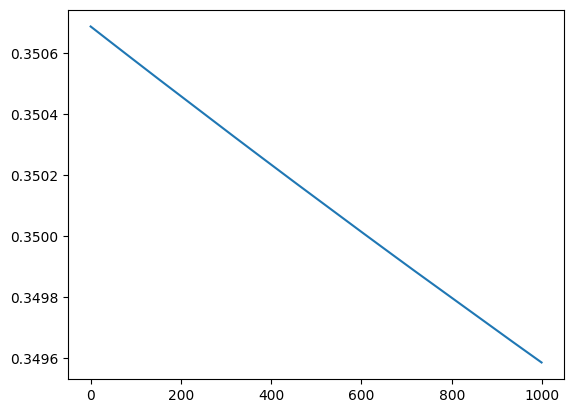

In [239]:
# optimize the mean_l to minimize the distance using gradient descent
optimizer = optim.SGD([mean_l], lr=0.001)
dists = []
for i in range(1000):
    out = x @ mean_l.t()
    # out = F.softmax(out, dim=1)
    # print(out)
    x_pred = out @ mean_l
    dist = F.mse_loss(x, x_pred, reduction='mean')
    optimizer.zero_grad()
    dist.backward()
    optimizer.step()
    dists.append(dist.item())
plt.plot(dists)
print(dist)
# print(mean_l)
# print(x_mean)
print(f"learned mean vs. true mean: {torch.abs(mean_l[0] - x_mean).sum()}")

In [240]:
# forward pass
out = x @ x_mean.unsqueeze(0).t()
out = F.softmax(out, dim=1)
x_pred = out @ x_mean.unsqueeze(0)
# distance between x and x_pred
dist = F.mse_loss(x, x_pred, reduction='mean')
print(dist)

tensor(0.0823)


In [132]:
# try this
n_samples_per_digit = 100
digits = [4, 9]

# get n_samples_per_digit samples for each digit
test_dataset = []
for digit in digits:
    digit_indices = np.where(mnist_train.targets == digit)[0]
    digit_indices = np.random.choice(digit_indices, n_samples_per_digit)
    test_dataset.append(mnist_train.data[digit_indices])
test_dataset = torch.cat(test_dataset) / 255.0
test_dataset = test_dataset.view(-1, 28 * 28).float()
test_labels = torch.cat([torch.zeros(n_samples_per_digit), torch.ones(n_samples_per_digit)])

# shuffle the dataset
shuffled_indices = torch.randperm(len(test_dataset))
test_dataset = test_dataset[shuffled_indices]
test_labels = test_labels[shuffled_indices]

In [198]:
dataset_mean = test_dataset.mean(dim=0)
class1_mean = test_dataset[test_labels == 0].mean(dim=0)
class2_mean = test_dataset[test_labels == 1].mean(dim=0)

mean_l = nn.Parameter(torch.rand(1, 28 * 28))
mean_r = 2 * dataset_mean - mean_l
layer_1_means = torch.cat([mean_l, mean_r], dim=0)
print(layer_1_means.shape)
# layer_1_means = mean_l


optimizer = optim.SGD([mean_l], lr=0.1)
losses = []

torch.Size([2, 784])


tensor(0.2770, grad_fn=<MseLossBackward0>)
mean_l vs. dataset_mean: 298.06396484375


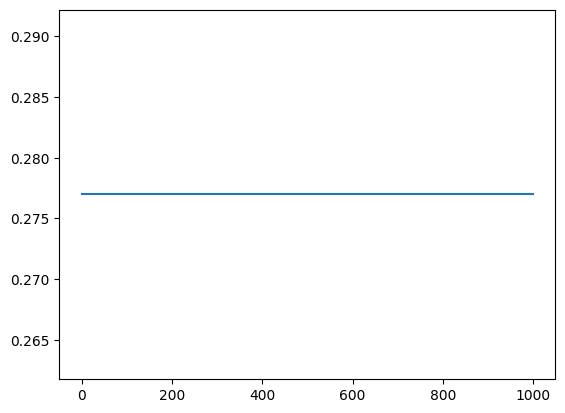

In [199]:
# mean_l = nn.Parameter(torch.rand(1, 28 * 28))
# # mean_r = 2 * dataset_mean - mean_l
# # layer_1_means = torch.cat([mean_l, mean_r], dim=0)
# layer_1_means = mean_l


# optimizer = optim.SGD([layer_1_means], lr=0.1)
# losses = []

for i in range(1000):
    out = test_dataset @ layer_1_means.t()
    out = F.softmax(out, dim=-1)
    x_pred = out @ layer_1_means
    dist = F.mse_loss(test_dataset, x_pred, reduction='mean')
    optimizer.zero_grad()
    dist.backward()
    optimizer.step()
    losses.append(dist.item())

plt.plot(losses)
print(dist)
# print(mean_l)
print(f"mean_l vs. dataset_mean: {torch.abs(mean_l - dataset_mean).sum()}")
# print(f"mean_l + mean_r vs. dataset_mean: {torch.abs(mean_l + mean_r - dataset_mean/2).sum()}")
# print(f"mean_l vs. class1_mean: {torch.abs(mean_l - class1_mean).sum()}")
# print(f"mean_r vs. class2_mean: {torch.abs(mean_r - class2_mean).sum()}")